<a href="https://colab.research.google.com/github/thehapyone/Thesis_Project/blob/master/Entity_Embeddings_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learned Embeddings
This program will attempt to create embeddings for the categorical features.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# using the latest updated file
data = pd.read_csv("drive/My Drive/Thesis/data/Data_Engineering/Edited_Raw_Data/v3_feature_engineering_data.csv", sep=',', low_memory=False)
#data = pd.read_csv("drive/My Drive/Thesis/data/Feature_Engineering/KNN_Imputed_Datasets/KNN_Imputed_k_40.csv", sep=',', low_memory=False)

#data = pd.read_csv("drive/My Drive/Thesis/data/Data_Engineering/Edited_Raw_Data/v2_Sorted_Database.csv", sep=',', low_memory=False)

In [4]:
data.shape

(19954, 435)

In [0]:
# the BIWEEK_SEND_DATE is a datetime feature and not just normal object date
data['BIWEEK_SEND_DATE'] = pd.to_datetime(data['BIWEEK_SEND_DATE'])

# Categorical Features
We have 70 categorical features inlcuding the Chassis feature.

The quesion pondering my mind is? Should the chassis feature be discared or used?

In [6]:
# find all categorical features.
data_cat = data.select_dtypes(include='object')
data_cat

,T_CHASSIS,VAR_DAX_AXLE_ARRANGEMENT,COUNTRY_OF_OPERATION,VAR_7MA_FRONT_AXLE_TYPE,VAR_DPX_ENGINE_TYPE,VAR_T1X_PTO_ENGINE_MOUNTED_REAR,VAR_4DX_FRONT_BUMPER,VAR_F1X_REAR_AXLE_LOAD,VAR_FTX_GROUND_CLEARANCE_FA,VAR_CKX_VEHICLE_PROFILE,VAR_KTX_ENGINE_EMISSION_CONTROL,VAR_3ZB_TRANSMISSION_PTO_TORQUE_CAP,VAR_QCX_TOPOGRAPHY,VAR_YLX_REAR_SUSPENSION_SYSTEM,VAR_DKX_GROSS_COMBINATION_WEIGHT,VAR_2RB_BATTERY_MAINTENANCE,VAR_FAX_STEERING_WHEEL_POS,VAR_2CX_CAB_VERSION,VAR_2DX_REAR_CAB_SUSPENSION,VAR_GSX_CHASSIS_HEIGHT,VAR_FFX_PUSHER_AXLE_FEATURES,VAR_5CB_AIR_SUSP_FEATURE_SOFTWARE,VAR_2GB_CLUTCHABLE_AIR_COMPRESSOR,VAR_5NX_ENGINE_BLOCK_HEATER,VAR_TAX_REAR_AXLE_RATIO,VAR_A3A_IDLE_SHUTDOWN,VAR_2LX_FRONT_CAB_SUSPENSION,VAR_RUX_GEAR_SHIFTING_SYSTEM,VAR_U3X_BRAKE_FRONT,VAR_T4X_PTO_TRANSM_MOUNTED,VAR_UBX_HYDRAULIC_PUMP_ENG_MTD,VAR_4QB_BODYBUILDER_EL_INTERFCAB_CHAS,VAR_REX_CRANK_CASE_VENTILATION,VAR_78X_TRANSPORT_CYCLE,VAR_T2X_TRANSMISSIONRETARDER_COOLER,VAR_U4X_BRAKE_DRIVE_REAR,VAR_FVX_FRONT_AXLE_LOAD,VAR_VWX_COMPRESSOR_CAPACITY,VAR_H1B_TURBO_APPLICATION,VAR_FDX_REAR_AXLE_ARRANGEMENT,VAR_7PX_HYDRAULIC_PUMP_GEARBOX_MOUNTED,VAR_7NA_FRONT_SUSPENSION_INSTALLATION,VAR_LKX_DRIVER_STATE_SENSING_SYSTEM,VAR_QWX_TURBO,VAR_FZX_FRONT_AXLE_ARRANGEMENT,VAR_V6X_RETARDER,VAR_K4C_VEHICLE_UPTIME_SETTINGS,VAR_0RA_REGENERATION_CONTROLS_DPF,VAR_YKX_FRONT_SUSPENSION_SYSTEM,VAR_T3X_PTO_ENGINE_REAR_MOUNTED,VAR_PJX_ALTERNATOR_CAPACITY,VAR_41X_PARKING_HEATER,VAR_D7C_WHOLE_VEHICLE_TYPE_APPROVAL,VAR_5JB_TELEMATICS_COMMUNICAT_GATEWAYS,VAR_RWX_TRANSMISSION,VAR_DHX_ROAD_CONDITION,VAR_2EX_CAB_TILT_PUMP,VAR_D9C_EMISSION_LEVEL,VAR_DDX_CHASSIS_TYPE,VAR_O8A_ENGINE_PTO_TORQUE_CAPACITY,VAR_33A_CAB_HEIGHT,VAR_J2A_ACTIVE_STEERING,VAR_N9C_ADR_CLASSIFICATION,VFE_0001_HORSE_POWER,VFE_0002_GROSS_COMBINATION_WEIGHT_BIN,VFE_0003_ENGINE_GENERATION,VFE_0004_REAR_AXLE_LOAD_BIN,VFE_0005_REAR_AXLE_RATIO_BIN,VFE_0009_LTVF_TYPE,VFE_0007_CAB_HEIGHT
0,N-767941,6*4,DEU,FAT-RIG,ENG-VE16,WPTER,BUMP-B2,RAL26,FA-HIGH,TYPE-FH,EM-EU6,UTPTT,T-PFLAT,RSS-AIR,GCW44.0,UBAMAFRE,STWPOS-L,CAB-HSLP,RCABS-A,CHH-HIGH,UPAXLE,ASF-DL1,CLU-AIRC,UEBHEAT,RAT3.61,UEIDLESD,FCABS-M,GSS-AGS,BF-DIBAS,UPTOTR,UHPE,UBBCHAS,CCV-C,TC-CONST,WTCOOL,BR-DIBAS,FAL9.0,2COMP900,TURBO-D,RAA22,UHPG,FSI-LEAF,UDAS,TURB-HD,FAA1,URETARD,VUPT-A2,NONE,FSS-LEAF,PTOENG-R,24AL150B,PH-CAB2,WVTA-EC,TGW-3GWL,ATO35,RC-ROUGH,CTILTP-E,EML-BAS,TRACTOR,EPTT650,CABH215,UACTST,UADRC,High,Med,K,HIGH,RAL26,HEAVY_CONSTR,CABH215
1,N-767941,6*4,DEU,FAT-RIG,ENG-VE16,WPTER,BUMP-B2,RAL26,FA-HIGH,TYPE-FH,EM-EU6,UTPTT,T-PFLAT,RSS-AIR,GCW44.0,UBAMAFRE,STWPOS-L,CAB-HSLP,RCABS-A,CHH-HIGH,UPAXLE,ASF-DL1,CLU-AIRC,UEBHEAT,RAT3.61,UEIDLESD,FCABS-M,GSS-AGS,BF-DIBAS,UPTOTR,UHPE,UBBCHAS,CCV-C,TC-CONST,WTCOOL,BR-DIBAS,FAL9.0,2COMP900,TURBO-D,RAA22,UHPG,FSI-LEAF,UDAS,TURB-HD,FAA1,URETARD,VUPT-A2,NONE,FSS-LEAF,PTOENG-R,24AL150B,PH-CAB2,WVTA-EC,TGW-3GWL,ATO35,RC-ROUGH,CTILTP-E,EML-BAS,TRACTOR,EPTT650,CABH215,UACTST,UADRC,High,Med,K,HIGH,RAL26,HEAVY_CONSTR,CABH215
2,N-767941,6*4,DEU,FAT-RIG,ENG-VE16,WPTER,BUMP-B2,RAL26,FA-HIGH,TYPE-FH,EM-EU6,UTPTT,T-PFLAT,RSS-AIR,GCW44.0,UBAMAFRE,STWPOS-L,CAB-HSLP,RCABS-A,CHH-HIGH,UPAXLE,ASF-DL1,CLU-AIRC,UEBHEAT,RAT3.61,UEIDLESD,FCABS-M,GSS-AGS,BF-DIBAS,UPTOTR,UHPE,UBBCHAS,CCV-C,TC-CONST,WTCOOL,BR-DIBAS,FAL9.0,2COMP900,TURBO-D,RAA22,UHPG,FSI-LEAF,UDAS,TURB-HD,FAA1,URETARD,VUPT-A2,NONE,FSS-LEAF,PTOENG-R,24AL150B,PH-CAB2,WVTA-EC,TGW-3GWL,ATO35,RC-ROUGH,CTILTP-E,EML-BAS,TRACTOR,EPTT650,CABH215,UACTST,UADRC,High,Med,K,HIGH,RAL26,HEAVY_CONSTR,CABH215
3,O-731397,6*2,DEU,FAT-RIG,ENG-VE11,WPTER,BUMP-B,RAL19,FA-LOW,TYPE-FM,EM-EU6,UTPTT,T-PFLAT,RSS-AIR,GCW44.0,UBAMAFRE,STWPOS-L,CAB-DAY,RCABS-M,CHH-MED,UPAXLE,ASF-DL3,UCLUAIRC,UEBHEAT,RAT2.85,UEIDLESD,FCABS-M,GSS-AGS,BF-DIBAS,UPTOTR,UHPE,BBCHAS3,CCV-C,TC-DISTR,UTCOOL,BR-DIBAS,FAL8.0,2COM1100,TURBO-S,RAA21T,UHPG,FSI-REAC,UDAS,TURB-HD,FAA1,URETARD,VUPT-A2,NONE,FSS-AIR,PTOENG-R,24AL150B,PH-CAB2,WVTA-EC,TGW-3GWL,AT261,RC-SMOOT,CTILTP-M,EML-BAS,RIGID,EPTT650,CABH165,UACTST,UADRC,Med,Med,K,RAL19,RAL19,INTERREG_HAUL,CABH165
4,

### No missing values in the categorical data


In [7]:
# check if we have any missing values in the categorical data
data_cat.isnull().sum().sum()

0

In [8]:
# it seems some categorical features have the same values i.e std of 0
data_cat['VAR_2RB_BATTERY_MAINTENANCE'].unique()

array(['UBAMAFRE', 'BAMAFREE'], dtype=object)

In [9]:
## find categorical features with zero variance - Will don't need those features.
data_cat.columns
var_1_categories = []
for col in data_cat.columns:
  unique_Values = data_cat.loc[:, col].nunique()
  print (col, unique_Values)
  if unique_Values == 1:
    var_1_categories.append(col)


T_CHASSIS 445
VAR_DAX_AXLE_ARRANGEMENT 4
COUNTRY_OF_OPERATION 1
VAR_7MA_FRONT_AXLE_TYPE 2
VAR_DPX_ENGINE_TYPE 3
VAR_T1X_PTO_ENGINE_MOUNTED_REAR 2
VAR_4DX_FRONT_BUMPER 3
VAR_F1X_REAR_AXLE_LOAD 9
VAR_FTX_GROUND_CLEARANCE_FA 3
VAR_CKX_VEHICLE_PROFILE 2
VAR_KTX_ENGINE_EMISSION_CONTROL 2
VAR_3ZB_TRANSMISSION_PTO_TORQUE_CAP 5
VAR_QCX_TOPOGRAPHY 3
VAR_YLX_REAR_SUSPENSION_SYSTEM 2
VAR_DKX_GROSS_COMBINATION_WEIGHT 9
VAR_2RB_BATTERY_MAINTENANCE 2
VAR_FAX_STEERING_WHEEL_POS 1
VAR_2CX_CAB_VERSION 5
VAR_2DX_REAR_CAB_SUSPENSION 2
VAR_GSX_CHASSIS_HEIGHT 4
VAR_FFX_PUSHER_AXLE_FEATURES 2
VAR_5CB_AIR_SUSP_FEATURE_SOFTWARE 3
VAR_2GB_CLUTCHABLE_AIR_COMPRESSOR 2
VAR_5NX_ENGINE_BLOCK_HEATER 2
VAR_TAX_REAR_AXLE_RATIO 22
VAR_A3A_IDLE_SHUTDOWN 2
VAR_2LX_FRONT_CAB_SUSPENSION 2
VAR_RUX_GEAR_SHIFTING_SYSTEM 3
VAR_U3X_BRAKE_FRONT 3
VAR_T4X_PTO_TRANSM_MOUNTED 2
VAR_UBX_HYDRAULIC_PUMP_ENG_MTD 2
VAR_4QB_BODYBUILDER_EL_INTERFCAB_CHAS 3
VAR_REX_CRANK_CASE_VENTILATION 3
VAR_78X_TRANSPORT_CYCLE 3
VAR_T2X_TRANSMISSIONRETA

In [10]:
# Categorical Variables with only 1 value. i.e std is 0
var_1_categories

['COUNTRY_OF_OPERATION', 'VAR_FAX_STEERING_WHEEL_POS']

## Embeddings

In order to apply embeddings for out categorical variables. We need to first determine which features are categorical variable and which are not. We need to ensure we caputure all possible cases of the categorical features. 

Okay, then for each categorical variable we need to capture the cardinalty of the feature iteself.

In [11]:
# we are going to discard the T_CHASSIS feature
categorical_features = data_cat.columns[1:]
categorical_features

Index(['VAR_DAX_AXLE_ARRANGEMENT', 'COUNTRY_OF_OPERATION',
       'VAR_7MA_FRONT_AXLE_TYPE', 'VAR_DPX_ENGINE_TYPE',
       'VAR_T1X_PTO_ENGINE_MOUNTED_REAR', 'VAR_4DX_FRONT_BUMPER',
       'VAR_F1X_REAR_AXLE_LOAD', 'VAR_FTX_GROUND_CLEARANCE_FA',
       'VAR_CKX_VEHICLE_PROFILE', 'VAR_KTX_ENGINE_EMISSION_CONTROL',
       'VAR_3ZB_TRANSMISSION_PTO_TORQUE_CAP', 'VAR_QCX_TOPOGRAPHY',
       'VAR_YLX_REAR_SUSPENSION_SYSTEM', 'VAR_DKX_GROSS_COMBINATION_WEIGHT',
       'VAR_2RB_BATTERY_MAINTENANCE', 'VAR_FAX_STEERING_WHEEL_POS',
       'VAR_2CX_CAB_VERSION', 'VAR_2DX_REAR_CAB_SUSPENSION',
       'VAR_GSX_CHASSIS_HEIGHT', 'VAR_FFX_PUSHER_AXLE_FEATURES',
       'VAR_5CB_AIR_SUSP_FEATURE_SOFTWARE',
       'VAR_2GB_CLUTCHABLE_AIR_COMPRESSOR', 'VAR_5NX_ENGINE_BLOCK_HEATER',
       'VAR_TAX_REAR_AXLE_RATIO', 'VAR_A3A_IDLE_SHUTDOWN',
       'VAR_2LX_FRONT_CAB_SUSPENSION', 'VAR_RUX_GEAR_SHIFTING_SYSTEM',
       'VAR_U3X_BRAKE_FRONT', 'VAR_T4X_PTO_TRANSM_MOUNTED',
       'VAR_UBX_HYDRAULIC_PUMP_ENG_MT

In [12]:
# fetch cardinality of out categorical variables.
cat_cardinality = [(cols, data_cat[cols].nunique()) for cols in categorical_features]
cat_cardinality

[('VAR_DAX_AXLE_ARRANGEMENT', 4),
 ('COUNTRY_OF_OPERATION', 1),
 ('VAR_7MA_FRONT_AXLE_TYPE', 2),
 ('VAR_DPX_ENGINE_TYPE', 3),
 ('VAR_T1X_PTO_ENGINE_MOUNTED_REAR', 2),
 ('VAR_4DX_FRONT_BUMPER', 3),
 ('VAR_F1X_REAR_AXLE_LOAD', 9),
 ('VAR_FTX_GROUND_CLEARANCE_FA', 3),
 ('VAR_CKX_VEHICLE_PROFILE', 2),
 ('VAR_KTX_ENGINE_EMISSION_CONTROL', 2),
 ('VAR_3ZB_TRANSMISSION_PTO_TORQUE_CAP', 5),
 ('VAR_QCX_TOPOGRAPHY', 3),
 ('VAR_YLX_REAR_SUSPENSION_SYSTEM', 2),
 ('VAR_DKX_GROSS_COMBINATION_WEIGHT', 9),
 ('VAR_2RB_BATTERY_MAINTENANCE', 2),
 ('VAR_FAX_STEERING_WHEEL_POS', 1),
 ('VAR_2CX_CAB_VERSION', 5),
 ('VAR_2DX_REAR_CAB_SUSPENSION', 2),
 ('VAR_GSX_CHASSIS_HEIGHT', 4),
 ('VAR_FFX_PUSHER_AXLE_FEATURES', 2),
 ('VAR_5CB_AIR_SUSP_FEATURE_SOFTWARE', 3),
 ('VAR_2GB_CLUTCHABLE_AIR_COMPRESSOR', 2),
 ('VAR_5NX_ENGINE_BLOCK_HEATER', 2),
 ('VAR_TAX_REAR_AXLE_RATIO', 22),
 ('VAR_A3A_IDLE_SHUTDOWN', 2),
 ('VAR_2LX_FRONT_CAB_SUSPENSION', 2),
 ('VAR_RUX_GEAR_SHIFTING_SYSTEM', 3),
 ('VAR_U3X_BRAKE_FRONT', 3),
 ('

In [13]:
# check out which feature has the maximum cardinality
#max_cardinality = max(np.array(cat_cardinality)[:,1])
max_cad_feature = np.argmax(np.array(cat_cardinality)[:,1].astype(int))
max_cardinality = cat_cardinality[max_cad_feature]
max_cardinality


('VAR_TAX_REAR_AXLE_RATIO', 22)

In [14]:
# I use the cardinality of each variable to decide how large its embedding matrix should be.
# max size of 10
embedding_size = np.array([(col_names, c, min(10, (c+1)//2)) for col_names,c in cat_cardinality])
embedding_size.shape

(69, 3)

In [15]:
# create a dataframe of the features and their sizes
cat_features_df = pd.DataFrame(data=embedding_size, columns=['Feature', 'Cardinality', 'Embedding_Size'])
# transform the dtypes
cat_features_df = cat_features_df.astype({'Cardinality': 'int32', 'Embedding_Size': 'int32'}, copy=False)
cat_features_df

,Feature,Cardinality,Embedding_Size
0,VAR_DAX_AXLE_ARRANGEMENT,4,2
1,COUNTRY_OF_OPERATION,1,1
2,VAR_7MA_FRONT_AXLE_TYPE,2,1
3,VAR_DPX_ENGINE_TYPE,3,2
4,VAR_T1X_PTO_ENGINE_MOUNTED_REAR,2,1
...,...,...,...
64,VFE_0003_ENGINE_GENERATION,3,2
65,VFE_0004_REAR_AXLE_LOAD_BIN,7,4
66,VFE_0005_REAR_AXLE_RATIO_BIN,10,5
67,VFE_0009_LTVF_TYPE,5,3


In [16]:
for feature in cat_features_df:
  print (feature)

Feature
Cardinality
Embedding_Size


In [17]:
# use tensorflow version 2
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Reshape, Concatenate, Dense, Flatten

from tensorflow.keras.callbacks import TensorBoard
import os
import datetime

from tensorflow.keras.utils import plot_model

### Creating the Keras Embeddings

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard


In [0]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [0]:
### Creating the Keras Embeddings

# IDs representing 1-hot encodings
# Need to create the input for all features
cat_embedding_input_layers = []

# Embeddings for the first cat feature
id_feature = 0
# create an array of embeddings layers
cat_embedding_layers = []
# interate through categorical varaibles
for id_feature in range(cat_features_df.shape[0]):
  # creating the input layer for the embeddings
  input_layer = Input(shape=(1,), name="Input_layer_"+cat_features_df.loc[id_feature, 'Feature'])
  cat_embedding_input_layers.append(input_layer)

  # creat the embedding layers
  embedded_layer = Embedding(input_dim=cat_features_df.loc[id_feature, 'Cardinality'], output_dim=10, name="Embedding_layer_"+cat_features_df.loc[id_feature, 'Feature'])(input_layer)
  cat_embedding_layers.append(embedded_layer)

#

In [33]:
fallatten_layer = Concatenate(cat_embedding_layers)
hidden_1 = Dense(1024, activation='relu')(fallatten_layer)


AttributeError: ignored

In [30]:
fallatten_layer

In [0]:
'''
# Reshape and merge all embeddings together
reshape = Reshape(target_shape=(10,))
combined = Concatenate([reshape(prior), reshape(store), reshape(shopper)])
'''

In [0]:
### creating the embedding model
model_emb = Model(inputs=cat_embedding_input_layers, outputs=cat_embedding_layers, name="Categorical_Embeddings")

# compile the model
model_emb.compile(optimizer='rmsprop', loss='mse')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.196214 to fit



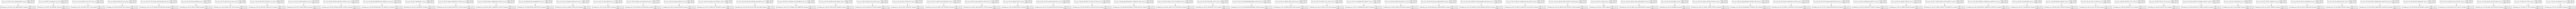

In [26]:
# plot the model
plot_model(model=model_emb, to_file='model_emp.png', show_shapes=True, dpi=300)

In [25]:
model_emb.summary()

Model: "Categorical_Embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer_VAR_DAX_AXLE_ARRANG [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_layer_COUNTRY_OF_OPERATIO [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_layer_VAR_7MA_FRONT_AXLE_ [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_layer_VAR_DPX_ENGINE_TYPE [(None, 1)]          0                                            
_____________________________________________________________________________

In [0]:
x = np.array([1,0,1,0]).reshape(4,1)
x

In [0]:
model_emb.predict(x)

In [0]:
# creating the embedding model
model = Sequential()

# here
'''
input_dim = Means the vocabulary size of the vector. I.e the max of a possible values the vector can hold. In our test case, then randomint generates value from 0 - 1000. So the vocabulary size is 100
output_dim = The dense vector dimension.
input_length = The dimension of the input vector. For example, the size of the one hot encoding.
'''
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be
# no larger than 999 (vocabulary size).
# create the embedding layer
model.add(Embedding(input_dim=2, output_dim=5, input_length=1, name="Embedding_Layer_1"))
# the output of this model : model.output_shape (None, 10, 64) where None is the batch dimension
model.compile(optimizer='rmsprop', loss='mse')

In [0]:
# check the model summary
model.summary()

In [0]:
input_array.shape

In [0]:
output_array = model.predict(x)
output_array

In [0]:
x1 = input_array[0]
x2 = input_array[1]

# calculating the cosing similarity of two vectors in the orginal space
a_dot = np.dot(x1, x2)
similar = a_dot / (np.linalg.norm(x1) * np.linalg.norm(x2))
similar

In [0]:
output_array[0].reshape(64,)

In [0]:
x1 = output_array[0].reshape(64,)
x2 = output_array[1].reshape(64,)

# calculating the cosing similarity of two vectors in the embedding space
a_dot = np.dot(x1, x2)
similar = a_dot / (np.linalg.norm(x1) * np.linalg.norm(x2))
similar